In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

2025-09-05 09:33:31.042151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757064811.396098      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757064811.500327      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
TRAIN_DATA_SIZE = 0.8
TEST_DATA_SIZE = 0.05
VALIDATION_DATA_SIZE = 0.15
CHANDIM = -1

In [3]:
data_set_path = "/kaggle/working/data-set"
primary_dataset_path = "/kaggle/input/new-paddy-doctor-paddy-disease-classification/paddy-disease-classification"
secondary_dataset_path= "/kaggle/input/paddy-doctor/paddy-disease-classification"
primary_data_set_train_path = os.path.join(primary_dataset_path, "train_images")
secondary_data_set_train_path = os.path.join(secondary_dataset_path, "train_images")
print("primary_dataset_path", primary_dataset_path)
print("secondary_dataset_path", secondary_dataset_path)
# data_set_test_path = os.path.join(data_set_path, "test_images")

primary_dataset_path /kaggle/input/new-paddy-doctor-paddy-disease-classification/paddy-disease-classification
secondary_dataset_path /kaggle/input/paddy-doctor/paddy-disease-classification


In [4]:
os.listdir(primary_data_set_train_path)

['tungro',
 'hispa',
 'downy_mildew',
 'bacterial_leaf_streak',
 'bacterial_leaf_blight',
 'brown_spot',
 'blast',
 'normal',
 'dead_heart',
 'bacterial_panicle_blight']

In [5]:
os.listdir(secondary_data_set_train_path)

['tungro',
 'hispa',
 'downy_mildew',
 'bacterial_leaf_streak',
 'bacterial_leaf_blight',
 'brown_spot',
 'blast',
 'normal',
 'dead_heart',
 'bacterial_panicle_blight']

# Data Visualization

In [6]:
import pandas as pd
def get_class_distribution(path, dataset_name):
    """Counts the number of files in each subdirectory of a given path."""
    class_counts = {}
    if not os.path.exists(path):
        print(f"Directory not found: {path}")
        return pd.DataFrame()

    for class_name in os.listdir(path):
        class_dir = os.path.join(path, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))

    df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count'])
    df = df.sort_values(by='count', ascending=False)
    df['dataset'] = dataset_name
    return df
    
primary_dist_df = get_class_distribution(primary_data_set_train_path, 'Primary')
secondary_dist_df = get_class_distribution(secondary_data_set_train_path, 'Secondary')

In [7]:
print("Class Distribution for Primary Dataset:")
print(primary_dist_df)
print("\nClass Distribution for Secondary Dataset:")
print(secondary_dist_df)

Class Distribution for Primary Dataset:
                          count  dataset
downy_mildew               1944  Primary
hispa                      1942  Primary
tungro                     1936  Primary
brown_spot                 1930  Primary
blast                      1918  Primary
bacterial_leaf_blight      1916  Primary
dead_heart                 1910  Primary
bacterial_leaf_streak      1900  Primary
normal                     1872  Primary
bacterial_panicle_blight   1863  Primary

Class Distribution for Secondary Dataset:
                          count    dataset
normal                     1764  Secondary
blast                      1738  Secondary
hispa                      1594  Secondary
dead_heart                 1442  Secondary
tungro                     1088  Secondary
brown_spot                  965  Secondary
downy_mildew                620  Secondary
bacterial_leaf_blight       479  Secondary
bacterial_leaf_streak       380  Secondary
bacterial_panicle_blight    337  Sec

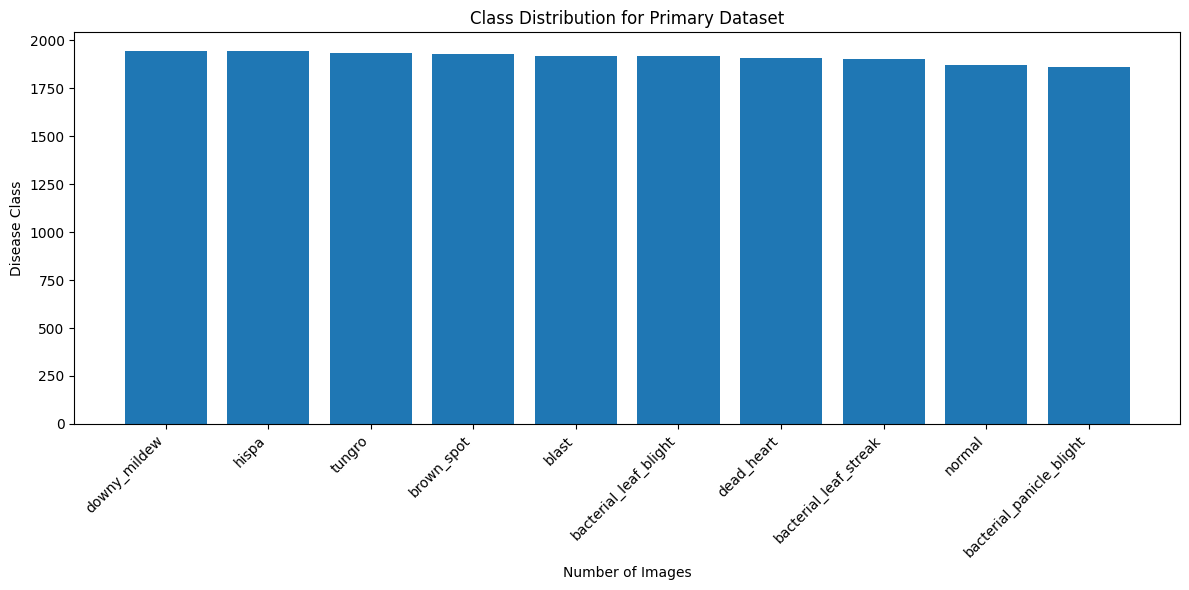

In [8]:
plt.figure(figsize=(12, 6))
plt.bar(primary_dist_df.index,primary_dist_df['count'])
plt.title('Class Distribution for Primary Dataset')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Number of Images')
plt.ylabel('Disease Class')
plt.tight_layout()
plt.show()

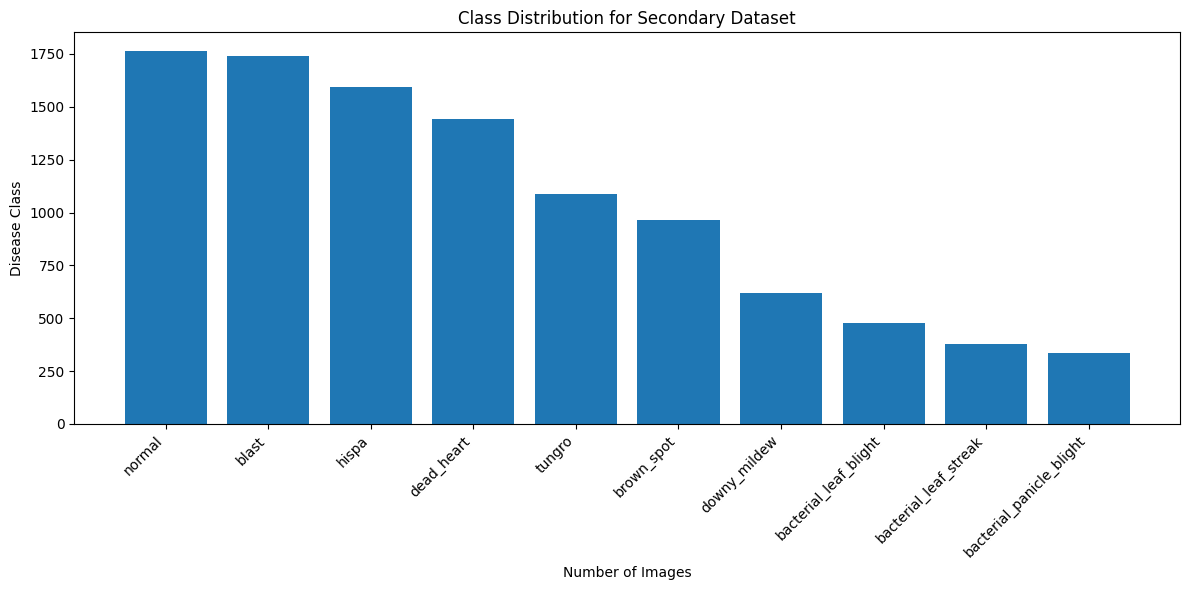

In [9]:
plt.figure(figsize=(12, 6))
plt.bar(secondary_dist_df.index,secondary_dist_df['count'])
plt.title('Class Distribution for Secondary Dataset')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Number of Images')
plt.ylabel('Disease Class')
plt.tight_layout()
plt.show()

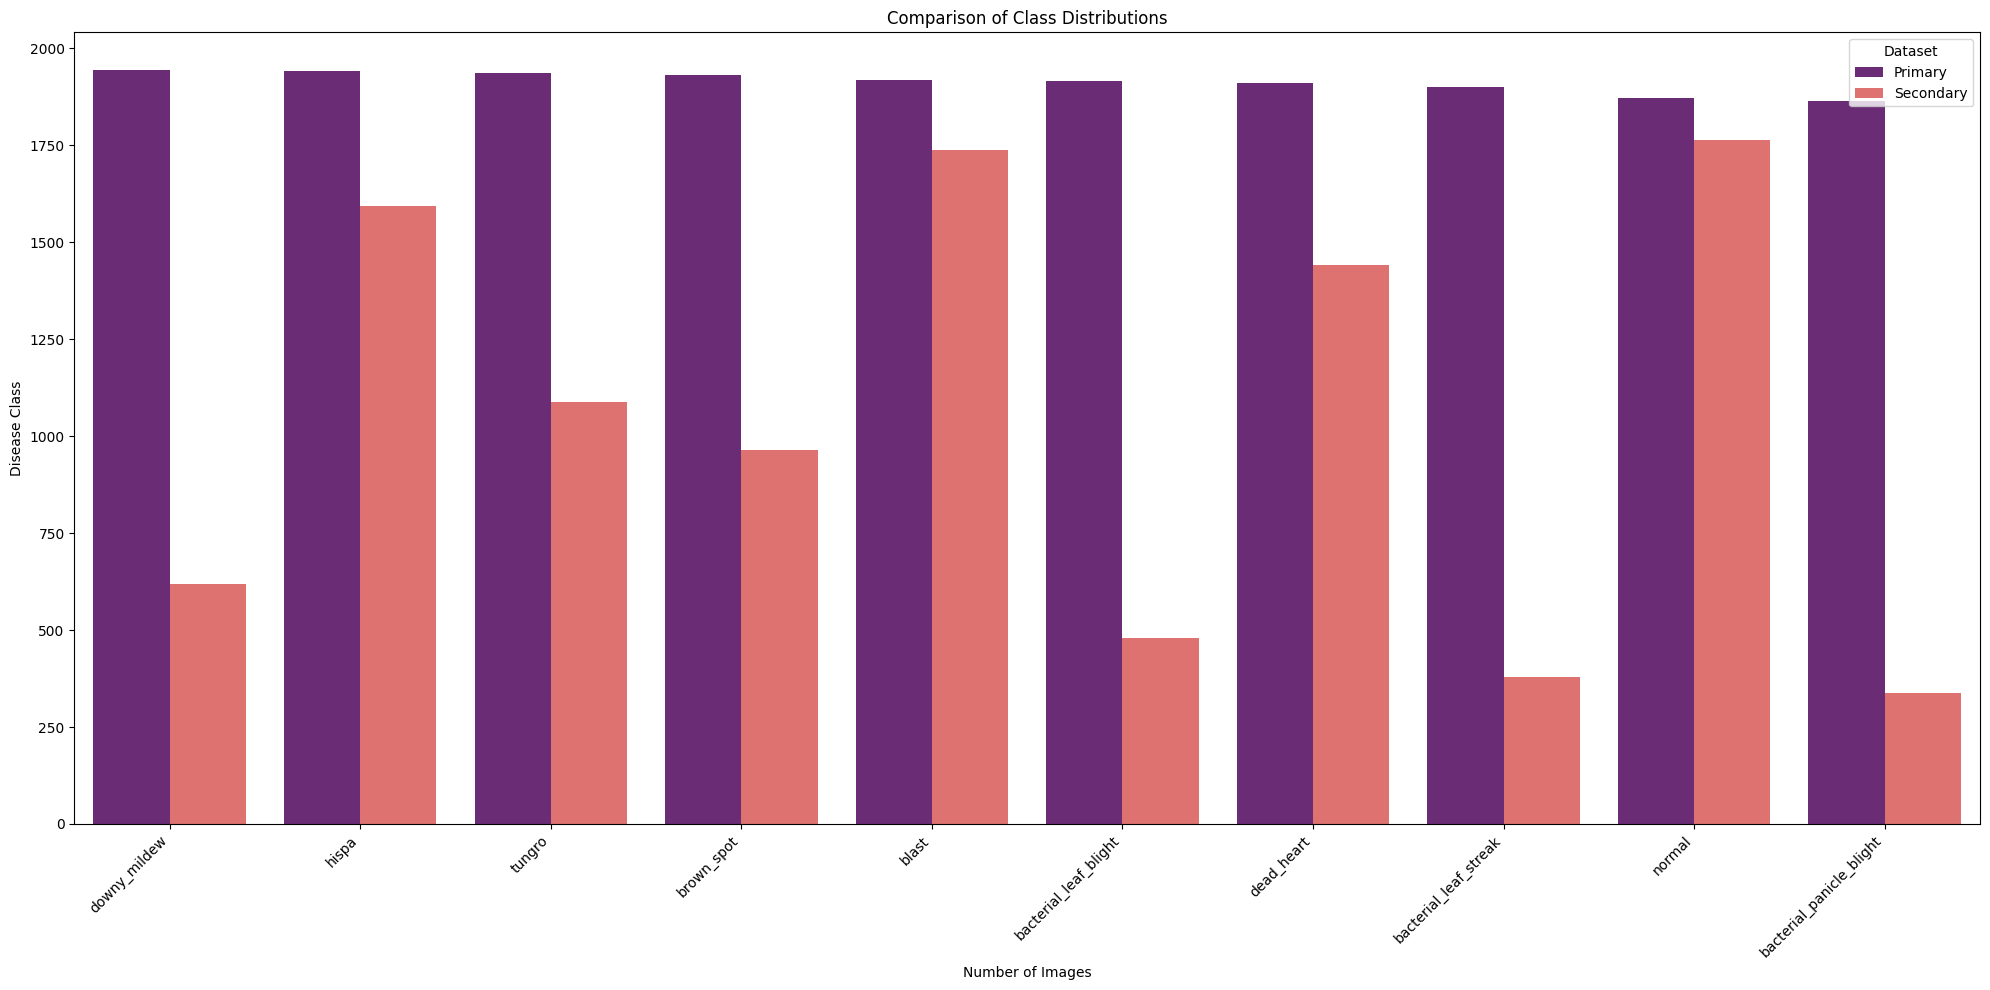

In [10]:
combined_df = pd.concat([primary_dist_df, secondary_dist_df])

plt.figure(figsize=(20, 10))
sns.barplot(y='count', x=combined_df.index, hue='dataset', data=combined_df, palette='magma')
plt.title('Comparison of Class Distributions')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Number of Images')
plt.ylabel('Disease Class')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Merge Two data sets

In [11]:
import shutil
import glob

In [12]:
# Prefix to add to the copied image filenames to avoid collisions
copy_prefix = 'new_'

# Classes you want to augment with more data
classes_to_augment = ['dead_heart', 'downy_mildew', 'hispa']

In [13]:
os.makedirs(data_set_path, exist_ok=True)

In [14]:
os.listdir(primary_data_set_train_path)

['tungro',
 'hispa',
 'downy_mildew',
 'bacterial_leaf_streak',
 'bacterial_leaf_blight',
 'brown_spot',
 'blast',
 'normal',
 'dead_heart',
 'bacterial_panicle_blight']

In [15]:
def merge_specific_classes(primary_path, new_data_path, classes, prefix=''):
    """
    Copies image files for specified classes from a new dataset to a primary dataset,
    adding a prefix to the filenames.
    """
    print("--- Starting Dataset Merge Process ---")
    total_files_copied = 0

    # Ensure the primary path exists
    if not os.path.exists(primary_path):
        print(f"[ERROR] Primary dataset path does not exist: {primary_path}")
        print("Please ensure you have copied your main dataset to a writable directory.")
        return

    for class_name in classes:
        print(f"\nProcessing class: '{class_name}'")

        # Define source and destination directories
        source_dir = os.path.join(primary_path, class_name)
        dest_dir = os.path.join(new_data_path, class_name)

        # --- Safety Checks ---
        if not os.path.exists(source_dir):
            print(f"  [WARNING] Source directory not found, skipping: {source_dir}")
            continue

        if not os.path.exists(dest_dir):
            print(f"  [INFO] Destination directory not found, creating it: {dest_dir}")
            os.makedirs(dest_dir)

        # Find all common image files in the source directory
        image_files = glob.glob(os.path.join(source_dir, '*.jpg')) + \
                      glob.glob(os.path.join(source_dir, '*.png'))

        if not image_files:
            print(f"  No new images found in {source_dir}")
            continue

        print(f"  Found {len(image_files)} images to copy from {source_dir}")
        files_copied_for_class = 0
        files_skipped = 0

        # Copy each file from source to destination
        for file_path in image_files:
            original_file_name = os.path.basename(file_path)
            
            # Smartly decide the destination filename
            # If the original file already exists, we must add a prefix.
            # Otherwise, we can just copy it as is.
            original_dest_path = os.path.join(dest_dir, original_file_name)
            prefixed_dest_path = os.path.join(dest_dir, f"{prefix}{original_file_name}")

            if not os.path.exists(original_dest_path):
                # If the original file doesn't exist, just copy it.
                dest_file_path = original_dest_path
            elif not os.path.exists(prefixed_dest_path):
                 # If the original exists, but the prefixed one doesn't, copy with prefix.
                dest_file_path = prefixed_dest_path
            else:
                # If both versions already exist, skip it.
                files_skipped += 1
                continue

            shutil.copy(file_path, dest_file_path)
            files_copied_for_class += 1

        print(f"  Successfully copied {files_copied_for_class} new images for class '{class_name}'.")
        if files_skipped > 0:
            print(f"  Skipped {files_skipped} files because they already existed in the destination.")
        total_files_copied += files_copied_for_class

    print(f"\n--- Merge Complete ---")
    print(f"Total new images added across specified classes: {total_files_copied}")

In [16]:
merge_specific_classes(primary_data_set_train_path,data_set_path,os.listdir(primary_data_set_train_path))

--- Starting Dataset Merge Process ---

Processing class: 'tungro'
  [INFO] Destination directory not found, creating it: /kaggle/working/data-set/tungro
  Found 1936 images to copy from /kaggle/input/new-paddy-doctor-paddy-disease-classification/paddy-disease-classification/train_images/tungro
  Successfully copied 1936 new images for class 'tungro'.

Processing class: 'hispa'
  [INFO] Destination directory not found, creating it: /kaggle/working/data-set/hispa
  Found 1942 images to copy from /kaggle/input/new-paddy-doctor-paddy-disease-classification/paddy-disease-classification/train_images/hispa
  Successfully copied 1942 new images for class 'hispa'.

Processing class: 'downy_mildew'
  [INFO] Destination directory not found, creating it: /kaggle/working/data-set/downy_mildew
  Found 1944 images to copy from /kaggle/input/new-paddy-doctor-paddy-disease-classification/paddy-disease-classification/train_images/downy_mildew
  Successfully copied 1944 new images for class 'downy_milde

In [17]:
merge_specific_classes(secondary_data_set_train_path,data_set_path,classes_to_augment,copy_prefix)

--- Starting Dataset Merge Process ---

Processing class: 'dead_heart'
  Found 1442 images to copy from /kaggle/input/paddy-doctor/paddy-disease-classification/train_images/dead_heart
  Successfully copied 1442 new images for class 'dead_heart'.

Processing class: 'downy_mildew'
  Found 620 images to copy from /kaggle/input/paddy-doctor/paddy-disease-classification/train_images/downy_mildew
  Successfully copied 620 new images for class 'downy_mildew'.

Processing class: 'hispa'
  Found 1594 images to copy from /kaggle/input/paddy-doctor/paddy-disease-classification/train_images/hispa
  Successfully copied 1594 new images for class 'hispa'.

--- Merge Complete ---
Total new images added across specified classes: 3656


In [18]:
finalized_dist_df = get_class_distribution(data_set_path,"final")
finalized_dist_df

count dataset
hispa                      3536   final
dead_heart                 3352   final
downy_mildew               2564   final
tungro                     1936   final
brown_spot                 1930   final
blast                      1918   final
bacterial_leaf_blight      1916   final
bacterial_leaf_streak      1900   final
normal                     1872   final
bacterial_panicle_blight   1863   final

In [19]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_set_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 22787 files belonging to 10 classes.


I0000 00:00:1757065078.902575      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757065078.903263      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Data Visualization

In [20]:
class_names = train_dataset.class_names
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

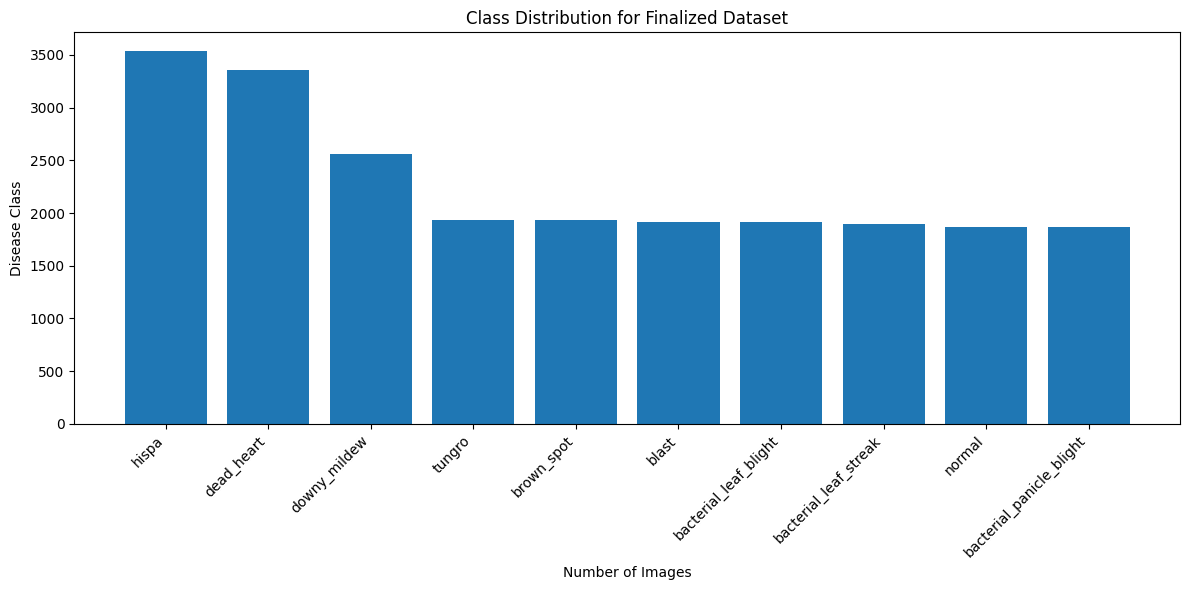

In [21]:
plt.figure(figsize=(12, 6))
plt.bar(finalized_dist_df.index,finalized_dist_df['count'])
plt.title('Class Distribution for Finalized Dataset')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Number of Images')
plt.ylabel('Disease Class')
plt.tight_layout()
plt.show()

In [22]:
def calculate_class_counts(dataset,folder_path):
  class_names = dataset.class_names
  class_counts = {}
  for class_name in class_names:
    class_dir = os.path.join(folder_path, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))
  return class_counts

In [23]:
dataset_class_counts = calculate_class_counts(train_dataset,data_set_path)

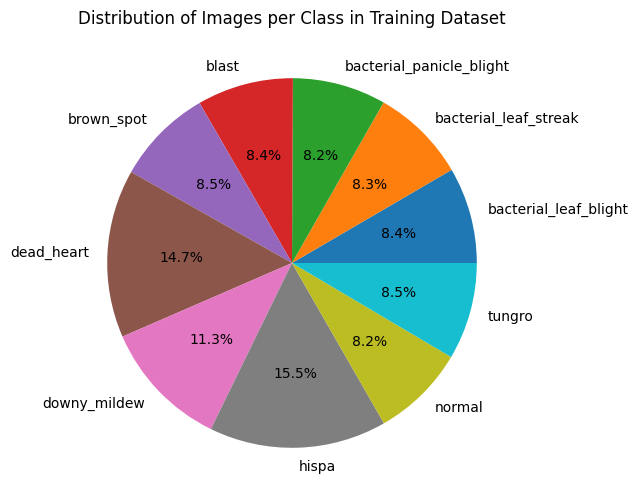

In [24]:
plt.figure(figsize=(12, 6))
plt.pie(dataset_class_counts.values(), labels=dataset_class_counts.keys(), autopct='%1.1f%%')
plt.title("Distribution of Images per Class in Training Dataset")
plt.show()

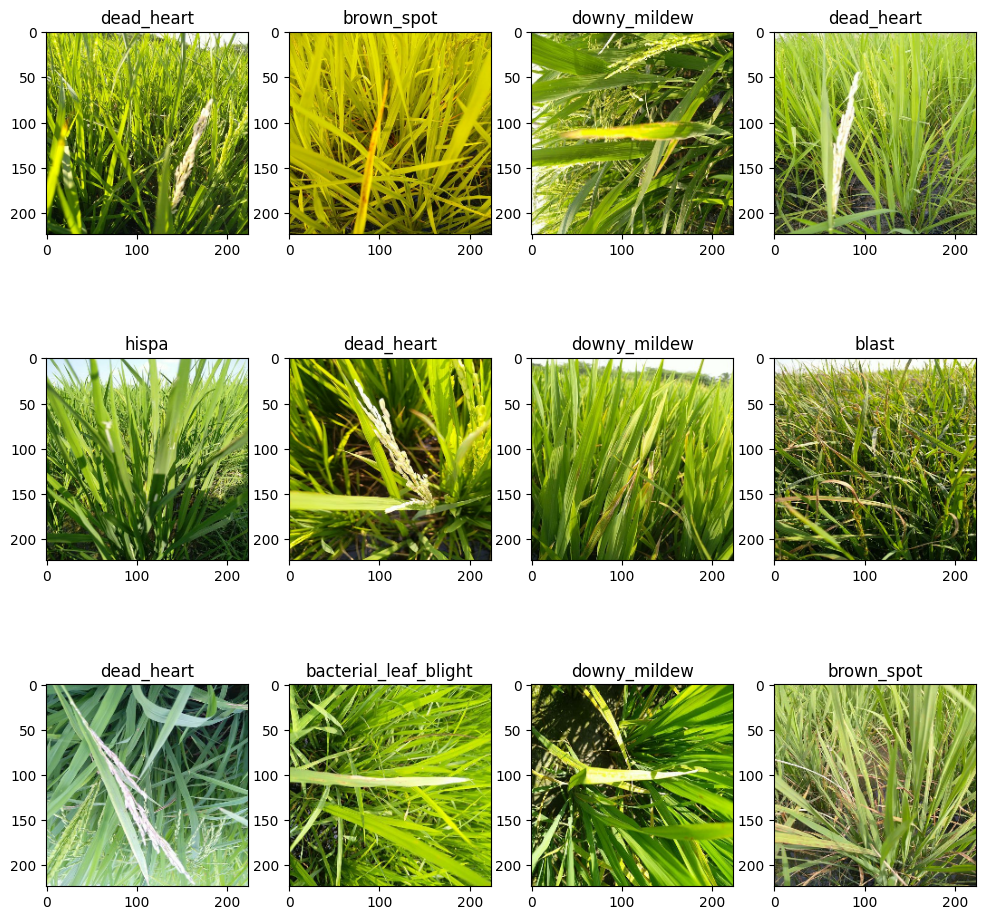

In [25]:
plt.figure(figsize=(12, 12))
for image_batch, label_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [26]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(train_dataset)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    validation_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,validation_ds,test_ds

In [27]:
train_ds,validation_ds,test_ds = get_dataset_partitions_tf(train_dataset,TRAIN_DATA_SIZE,VALIDATION_DATA_SIZE,TEST_DATA_SIZE)

In [28]:

len(train_ds),len(validation_ds),len(test_ds)

(570, 106, 37)

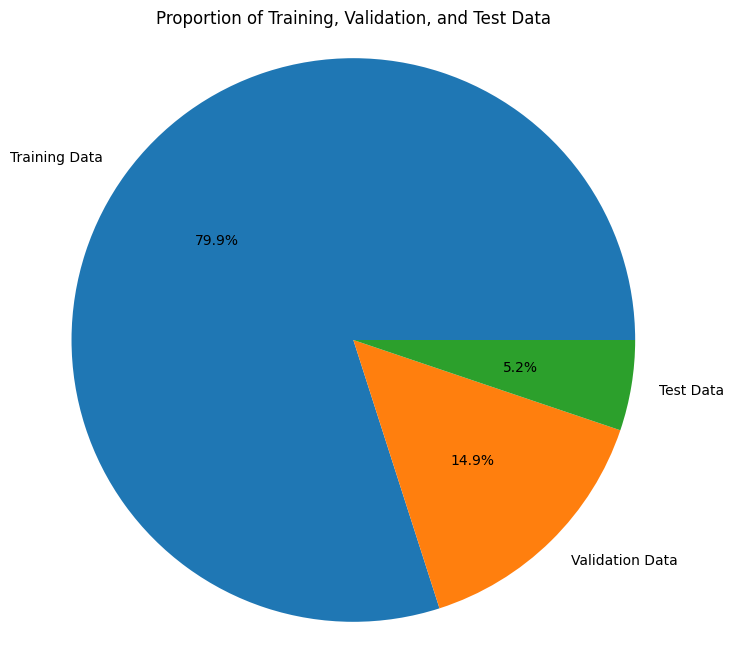

In [29]:
labels = ['Training Data', 'Validation Data', 'Test Data']
sizes = [len(train_ds), len(validation_ds), len(test_ds)]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=0)
plt.title("Proportion of Training, Validation, and Test Data")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Datasets optimization

In [30]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Image preprocessing

In [31]:
resize_and_scale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [32]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Model Build

In [33]:
input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_scale,
    data_augmentation,
    # Block 1
    layers.Conv2D(32, (3, 3), padding="same",activation='relu'),
    layers.BatchNormalization(axis=CHANDIM),
    layers.MaxPooling2D(pool_size=(3, 3)),
    layers.Dropout(0.25),
    
    # Block 2
    layers.Conv2D(64, (3, 3), padding="same",activation='relu'),
    layers.BatchNormalization(axis=CHANDIM),
    
    layers.Conv2D(64, (3, 3), padding="same",activation='relu'),
    layers.BatchNormalization(axis=CHANDIM),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(128, (3, 3), padding="same",activation='relu'),
    layers.BatchNormalization(axis=CHANDIM),

    layers.Conv2D(128, (3, 3), padding="same",activation='relu'),
    layers.BatchNormalization(axis=CHANDIM),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Fully Connected
    layers.Flatten(),
    layers.Dense(1024),
    layers.Activation("relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(len(class_names), activation='softmax')

])

In [34]:
model.build(input_shape=input_shape)

In [35]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 224, 224, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32, 224, 224, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 74, 74, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 74, 74, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 74, 74, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (32, 74, 74, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 74, 74, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (32, 74, 74, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 37, 37, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 37, 37, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 37, 37, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (32, 37, 37, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 37, 37, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (32, 37, 37, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 18, 18, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 18, 18, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 41472)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1024)             │    42,468,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (32, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (32, 1024)             │         4,096 │
│ (BatchNormalization)            │                        │             

 Total params: 42,762,122 (163.12 MB)

 Trainable params: 42,759,242 (163.11 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [36]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Model Training

In [37]:
history = model.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_ds,
                    verbose=1,
                    epochs=EPOCHS
)

Epoch 1/50


E0000 00:00:1757065091.197858      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1757065122.994882     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


570/570 ━━━━━━━━━━━━━━━━━━━━ 146s 182ms/step - accuracy: 0.2550 - loss: 2.5818 - val_accuracy: 0.2238 - val_loss: 2.6840
Epoch 2/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 124s 184ms/step - accuracy: 0.4921 - loss: 1.5457 - val_accuracy: 0.6141 - val_loss: 1.1479
Epoch 3/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 124s 183ms/step - accuracy: 0.5851 - loss: 1.2162 - val_accuracy: 0.5027 - val_loss: 1.5933
Epoch 4/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 124s 183ms/step - accuracy: 0.6538 - loss: 1.0238 - val_accuracy: 0.4157 - val_loss: 2.1236
Epoch 5/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 123s 183ms/step - accuracy: 0.6978 - loss: 0.8914 - val_accuracy: 0.6070 - val_loss: 1.1372
Epoch 6/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 123s 183ms/step - accuracy: 0.7435 - loss: 0.7500 - val_accuracy: 0.5852 - val_loss: 1.6300
Epoch 7/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 123s 183ms/step - accuracy: 0.7777 - loss: 0.6766 - val_accuracy: 0.1725 - val_loss: 14.2261
Epoch 8/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 123s 183ms/step - accuracy: 0.7192 - loss: 0.8

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

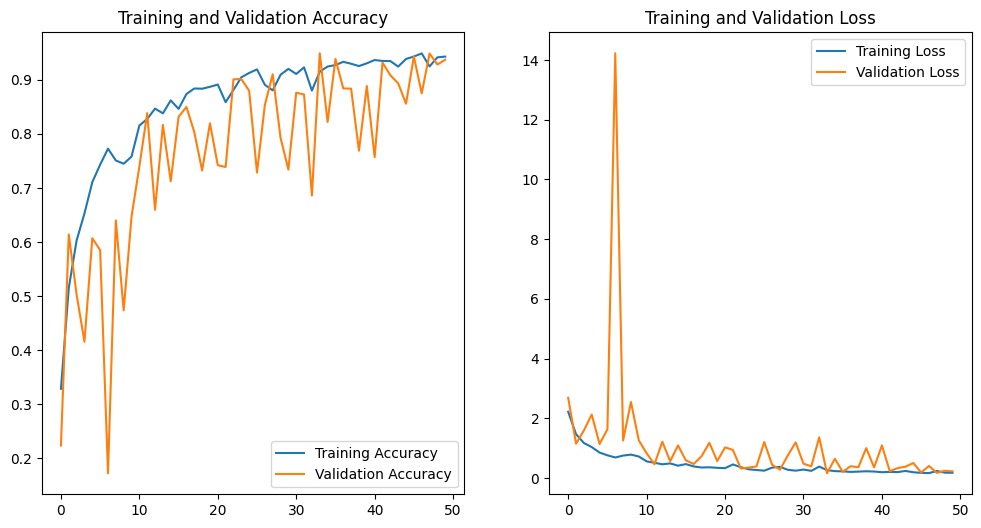

In [39]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: tungro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
predicted label: tungro


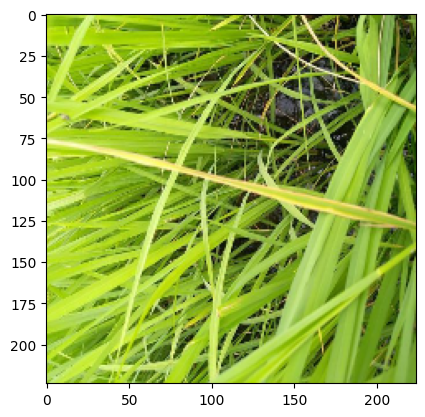

In [40]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model,image_array):
  img_array = tf.expand_dims(image_array, 0)
  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


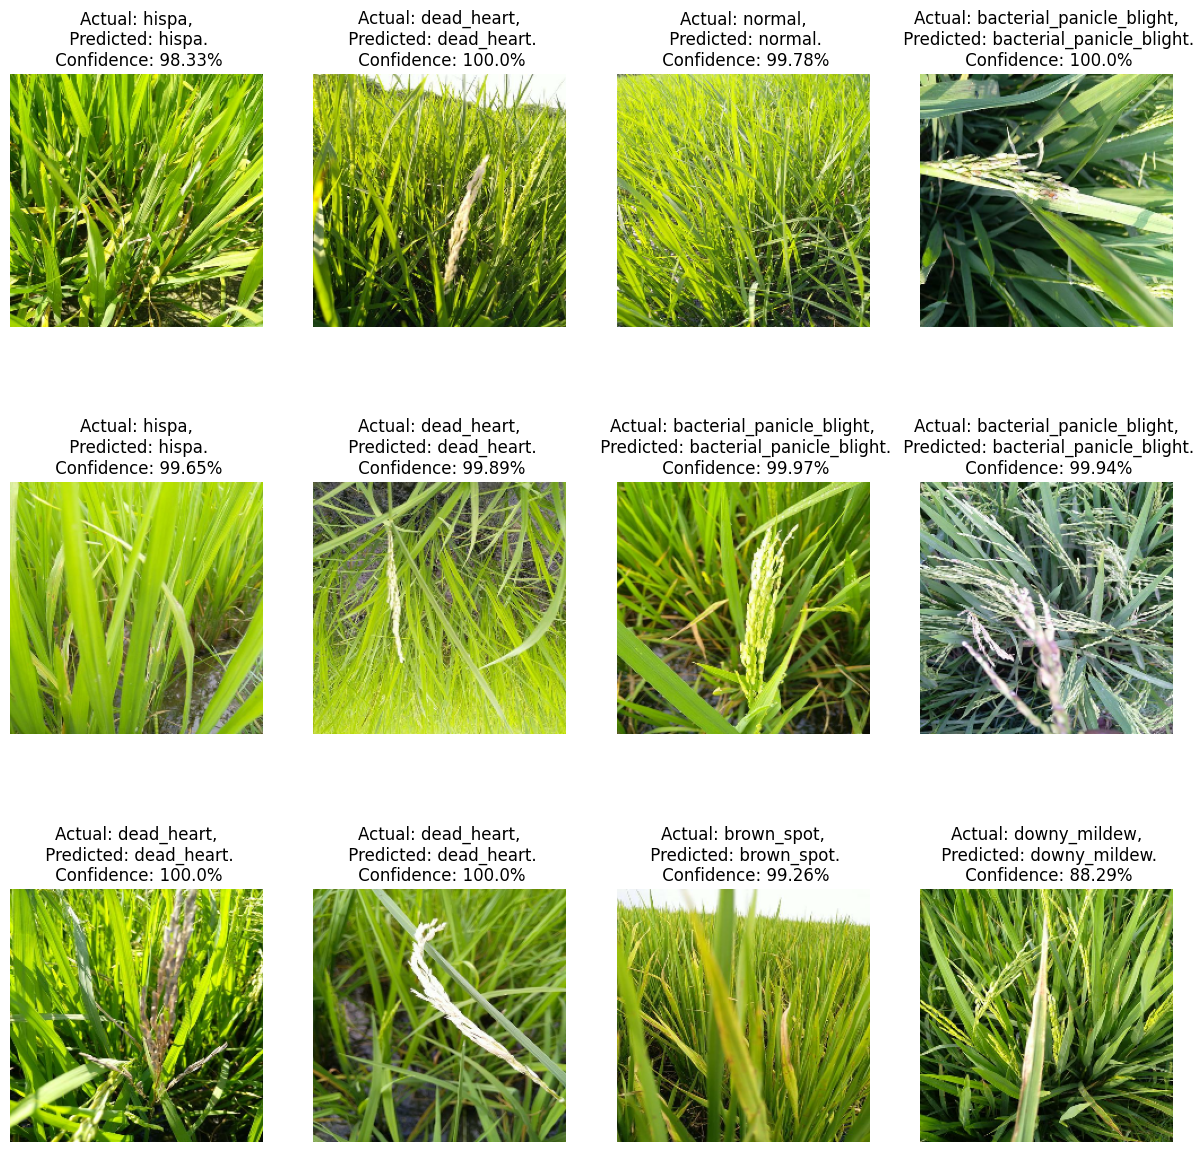

In [42]:
plt.figure(figsize=(15, 15))
for images,labels in test_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class, confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis("off")

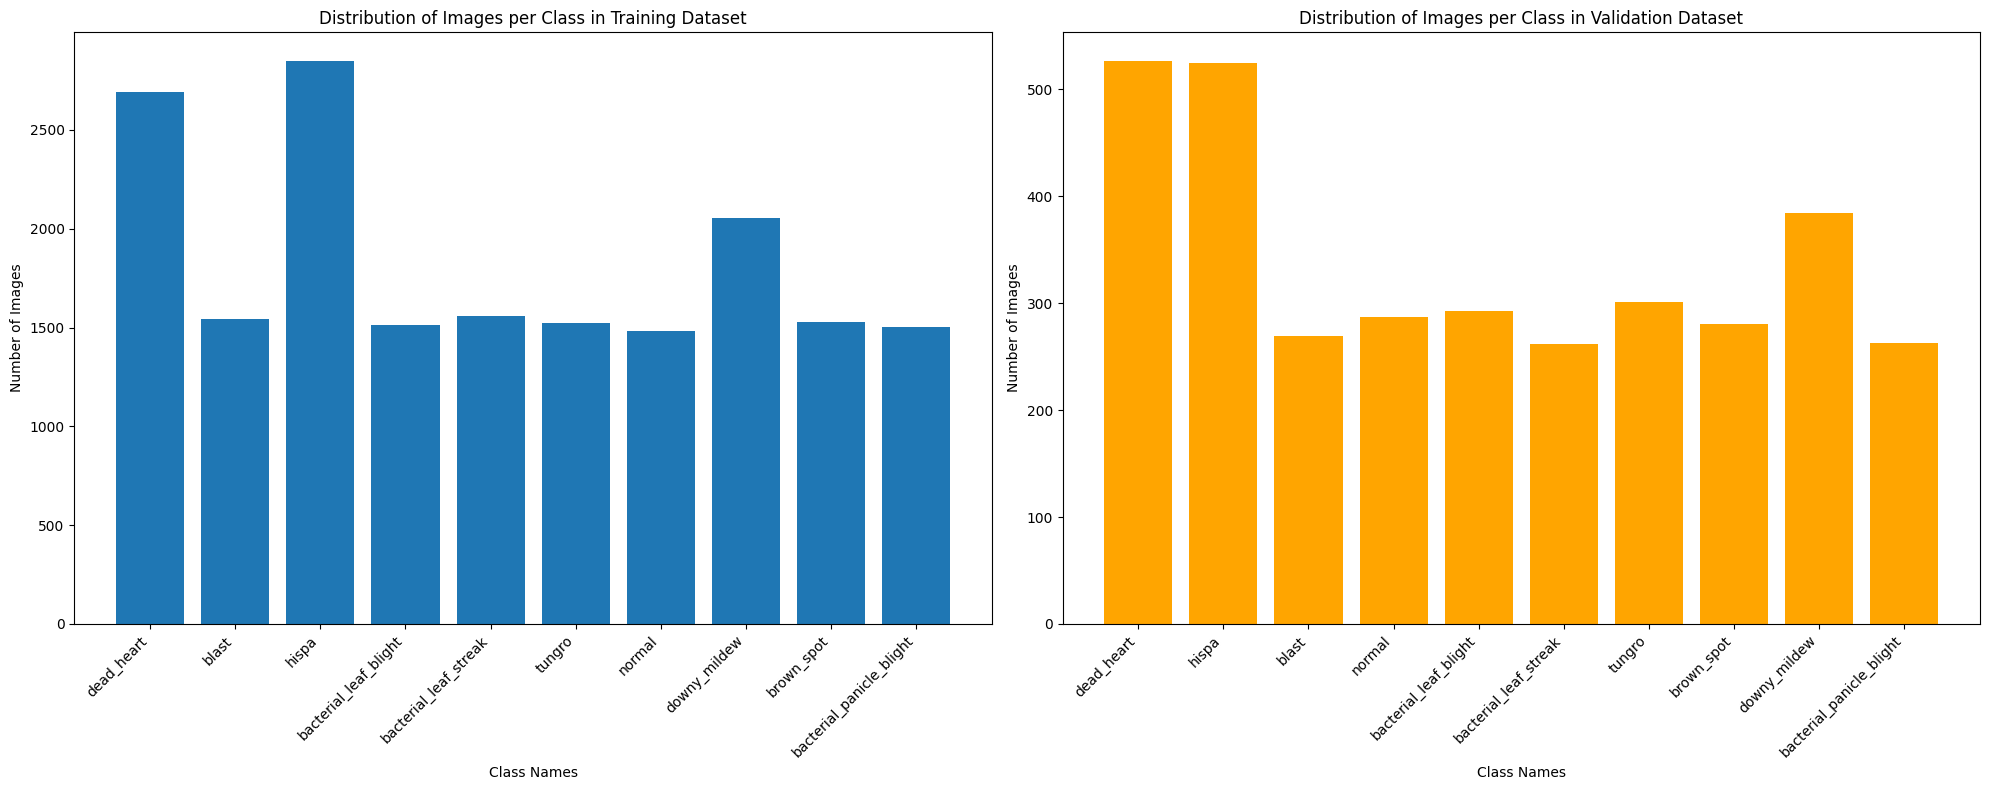

In [43]:
def calculate_class_counts(dataset):
    class_counts = {}
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    return class_counts

# Calculate class counts for training and validation datasets
train_class_counts = calculate_class_counts(train_ds)
validation_class_counts = calculate_class_counts(validation_ds)

# Create a figure with two subplots for side-by-side charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Bar chart for training data
ax1.bar(train_class_counts.keys(), train_class_counts.values())
ax1.set_title('Distribution of Images per Class in Training Dataset')
ax1.set_xlabel('Class Names')
ax1.set_ylabel('Number of Images')
ax1.set_xticks(range(len(train_class_counts.keys())))
ax1.set_xticklabels(train_class_counts.keys(), rotation=45, ha='right')


# Bar chart for validation data
ax2.bar(validation_class_counts.keys(), validation_class_counts.values(), color='orange')
ax2.set_title('Distribution of Images per Class in Validation Dataset')
ax2.set_xlabel('Class Names')
ax2.set_ylabel('Number of Images')
ax2.set_xticks(range(len(validation_class_counts.keys())))
ax2.set_xticklabels(validation_class_counts.keys(), rotation=45, ha='right')

fig.tight_layout()
plt.show()

# Model Eveluation

In [44]:
test_labels = []
predicted_labels = []

for images, labels in test_ds:
    for label in labels.numpy():
        test_labels.append(label)
    for prediction in model.predict(images):
        predicted_labels.append(np.argmax(prediction))

test_labels = np.array(test_labels)
predicted_labels = np.array(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(test_labels, predicted_labels, target_names=class_names))


Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.84      0.98      0.90        87
   bacterial_leaf_streak       0.99      0.99      0.99       104
bacterial_panicle_blight       1.00      1.00      1.00        93
                   blast       0.99      0.89      0.94       107
              brown_spot       0.93      0.95      0.94       106
              dead_heart       1.00      0.97      0.99       176
            downy_mildew       0.96      0.95      0.95       136
                   hispa       0.96      0.95      0.96       187
                  normal       0.93      0.93      0.93       100
                  tungro       0.83      0.85      0.84        88

                accuracy                           0.95      1184
               macro avg       0.94      0.95      0.94      1184
            weighted avg       0.95      0.95      0.95      1184



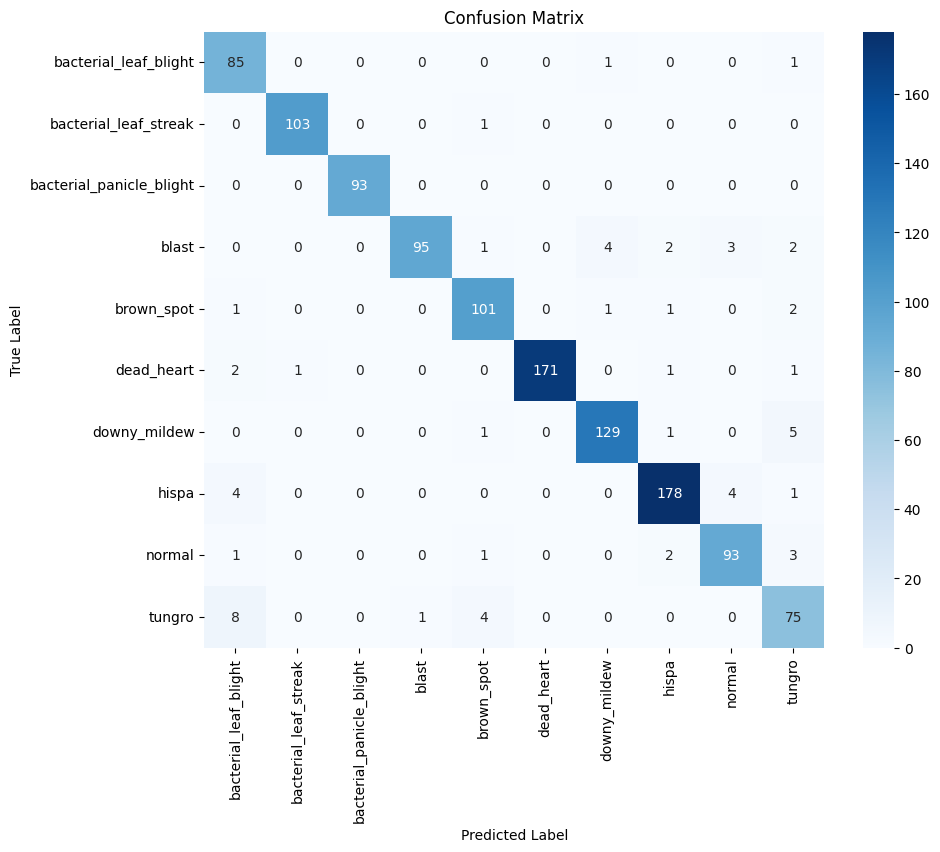

In [47]:
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()